<a href="https://colab.research.google.com/github/Cheetahabc/vue-project/blob/main/MobileNetV2_%E7%8E%89%E7%B1%B3%E6%A3%92_%E5%86%BB%E7%BB%93.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
import os
import time
import json
import glob

import matplotlib.pyplot as plt
from PIL import Image

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
%matplotlib inline
import os
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout,Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import seaborn as sns
sns.set()
import itertools
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#测试集
preddir = '/content/drive/MyDrive/zuizhong/test'

#训练集
traindir = '/content/drive/MyDrive/zuizhong/train'

#验证集
valdir = '/content/drive/MyDrive/zuizhong/val'

IMAGE_SIZE = 224
batch_size = 64
epochs = 100

In [ ]:
def show_predictions(model, preddir,IMAGE_SIZE,training_data, val):
    pred = ImageDataGenerator(rescale=1./255)
    pred = pred.flow_from_directory(
        preddir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=len(val.classes),
        shuffle=False
        )
    predictions = model.predict(pred, steps=1)
    preds = np.argmax(predictions,axis=1) 
    labels = (training_data.class_indices) 
    labels = dict((v,k) for k,v in labels.items()) 
    return [labels[k] for k in preds]

In [ ]:
def run_model(model, train_data, val_data, batch_size, epochs):
    history = model.fit(
        train_data,
        steps_per_epoch=353//batch_size,
        epochs=epochs,
        validation_data=val_data, 
        validation_steps=99//batch_size
        )
    return history

In [ ]:
def plot_confusion_matrix(pred, preddir, model, pred_gen, model_name):
    plt.rcParams.update({'font.size': 11})
    
    predictions = model.predict(pred, steps=1)
    preds = np.argmax(predictions,axis=1)
    predictions = tf.nn.softmax(predictions, axis=1)
    
    labels = (pred.classes)
    
    plot_labels = np.array([i for i in (pred.class_indices).keys()])
    
    cm = tf.math.confusion_matrix(labels, preds)

    ratio_correct = np.trace(cm)/np.sum(cm)
    ratio_incorrect = 1 - ratio_correct

    plt.figure(figsize=(10,8))
    plt.imshow(cm, interpolation='nearest', cmap='Reds')
    plt.colorbar()

    ticks = np.arange(len(plot_labels))
    plt.xticks(ticks, plot_labels, rotation=90)
    plt.yticks(ticks, plot_labels)

    plt.title(f'Confusion Matrix for {model_name}')
    plt.grid(b=False)

    threshold = 4
    for i, j in itertools.product(
        range(cm.shape[0]), 
        range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i,j]),
                 horizontalalignment='center',
                 color='white' if cm[i,j] > threshold else 'black')
    
    plt.tight_layout()
    plt.ylabel('Predicted')
    plt.xlabel('True Label\naccuracy={:0.4f}; ratio_incorrect={:0.4f}'.format(
        ratio_correct, ratio_incorrect
    ))

In [ ]:
def class_report(pred, model, pred_gen):
    predictions = model.predict(pred, steps=1)
    preds = np.argmax(predictions,axis=1)
    labels = (pred.classes)
    names = np.array([i for i in (pred.class_indices).keys()])
    df = pd.DataFrame.from_dict(classification_report(labels, preds, output_dict=True))
    combined = dict(zip(df.columns, names))
    return df.rename(columns=combined)

In [ ]:
def find_my_photo(predictions, df):
    answer = df.loc[df['name'] == predictions[0], 'coord']
    return (''.join(list(answer))).replace(' ', '')

In [ ]:
def plot_roc_curve(model, pred, pred_gen, model_name):
    predictions = model.predict(pred, steps=1)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    y_test_dummies = pd.get_dummies(pred.classes, drop_first=False).values
    for i in range(5):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fig, ax = plt.subplots(figsize=(18,13))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {model_name}')
    for i in range(5):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

In [ ]:
def plot_metrics(history_):
    plt.figure(figsize=(15,12))

    plt.subplot(1,2,1)
    plt.plot(history_.history['accuracy'], label='Training Accuracy')
    plt.plot(history_.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Validation Accuracy')
    plt.legend(loc='best')

    plt.subplot(1,2,2)
    plt.plot(history_.history['loss'], label='Training Loss')
    plt.plot(history_.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs. Validation Loss')
    plt.legend(loc='best')

    plt.tight_layout(pad=1)
    plt.show()

In [ ]:
def show_photo(image_generator):
    images, _ = next(image_generator)
    plt.figure(figsize=(120,120))
    for i, img in enumerate(images[:4]):
        plt.subplot(1,len(images),i+1)
        plt.grid(b=False)
        plt.axis('off')
        plt.imshow(img)
    plt.tight_layout()
    plt.show()

In [ ]:
def missed_img(folder_list, main, size): 
    img = mpimg.imread(traindir + f'/{main}/1.png')
    plt.grid(b=False)
    plt.axis('off')
    plt.title(f'Missed Image: {main}')
    plt.imshow(img)
    plt.show()
    plt.figure(figsize=(size))
    for i in range(len(folder_list)):
        plt.subplot(1,len(folder_list), i+1)
        img_ = mpimg.imread(traindir + f'/{folder_list[i]}/1.png')
        plt.title(f'Guessed Image instead of {main}: {folder_list[i]}')
        plt.grid(b=False)
        plt.axis('off')
        plt.imshow(img_)
    plt.tight_layout()
    plt.show()

In [ ]:
# for displaying images only
show_image_gen = ImageDataGenerator(rescale=1./255)

# for Image Augmentation of training data set
image_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    horizontal_flip=True,
    zoom_range=0.5,
    shear_range=0.3,
    height_shift_range=.15,
    width_shift_range=.15,
    fill_mode='nearest'
)

# for validation data set
val_gen = ImageDataGenerator(rescale=1./255)

# for making predictions
pred_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
show_images_before = show_image_gen.flow_from_directory(
    traindir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE), 
    batch_size=batch_size,
    shuffle=False
)

show_images_after = image_gen_train.flow_from_directory(
    traindir,
    target_size=(IMAGE_SIZE,IMAGE_SIZE), 
    batch_size=batch_size,
    shuffle=False
)

# creating training data set
train = image_gen_train.flow_from_directory(
    traindir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE), 
    batch_size=batch_size,
   
    )

# creating validation data set
val = val_gen.flow_from_directory(
    valdir, 
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=batch_size,
   
    )

# to be used later for assessing model
pred = pred_gen.flow_from_directory(
    preddir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=len(val.classes),
    shuffle=False
    )

Found 353 images belonging to 5 classes.
Found 353 images belonging to 5 classes.
Found 353 images belonging to 5 classes.
Found 99 images belonging to 5 classes.
Found 48 images belonging to 5 classes.


In [ ]:
X_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))

for layer in X_model.layers:
    layer.trainable = False


9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
X_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
top_model = Sequential()
top_model.add(GlobalAveragePooling2D())
top_model.add(Dense(256,activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(5,activation='softmax'))
model_x = Sequential()
model_x.add(X_model)
model_x.add(top_model)

In [ ]:
model_x.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 sequential (Sequential)     (None, 5)                 329221    
                                                                 
Total params: 2,587,205
Trainable params: 329,221
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [ ]:
model_x.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy',
              metrics= ['accuracy'])

In [ ]:
history_x = run_model(model_x, train, val, 64, epochs)

Epoch 1/100
5/5 [==============================] - 165s 31s/step - loss: 1.8490 - accuracy: 0.2625 - val_loss: 1.6766 - val_accuracy: 0.3594
Epoch 2/100
5/5 [==============================] - 43s 9s/step - loss: 1.3277 - accuracy: 0.4187 - val_loss: 1.1922 - val_accuracy: 0.4688
Epoch 4/100
5/5 [==============================] - 41s 9s/step - loss: 1.1167 - accuracy: 0.5536 - val_loss: 1.1408 - val_accuracy: 0.5625
Epoch 5/100
5/5 [==============================] - 41s 9s/step - loss: 1.0377 - accuracy: 0.5779 - val_loss: 1.1169 - val_accuracy: 0.5156
Epoch 6/100
5/5 [==============================] - 44s 9s/step - loss: 1.0381 - accuracy: 0.5906 - val_loss: 0.9729 - val_accuracy: 0.6406
Epoch 7/100
5/5 [==============================] - 42s 9s/step - loss: 0.9324 - accuracy: 0.6125 - val_loss: 0.8736 - val_accuracy: 0.7031
Epoch 8/100
5/5 [==============================] - 42s 9s/step - loss: 0.9414 - accuracy: 0.6228 - val_loss: 0.8218 - val_accuracy: 0.6719
Epoch 9/100
5/5 [========

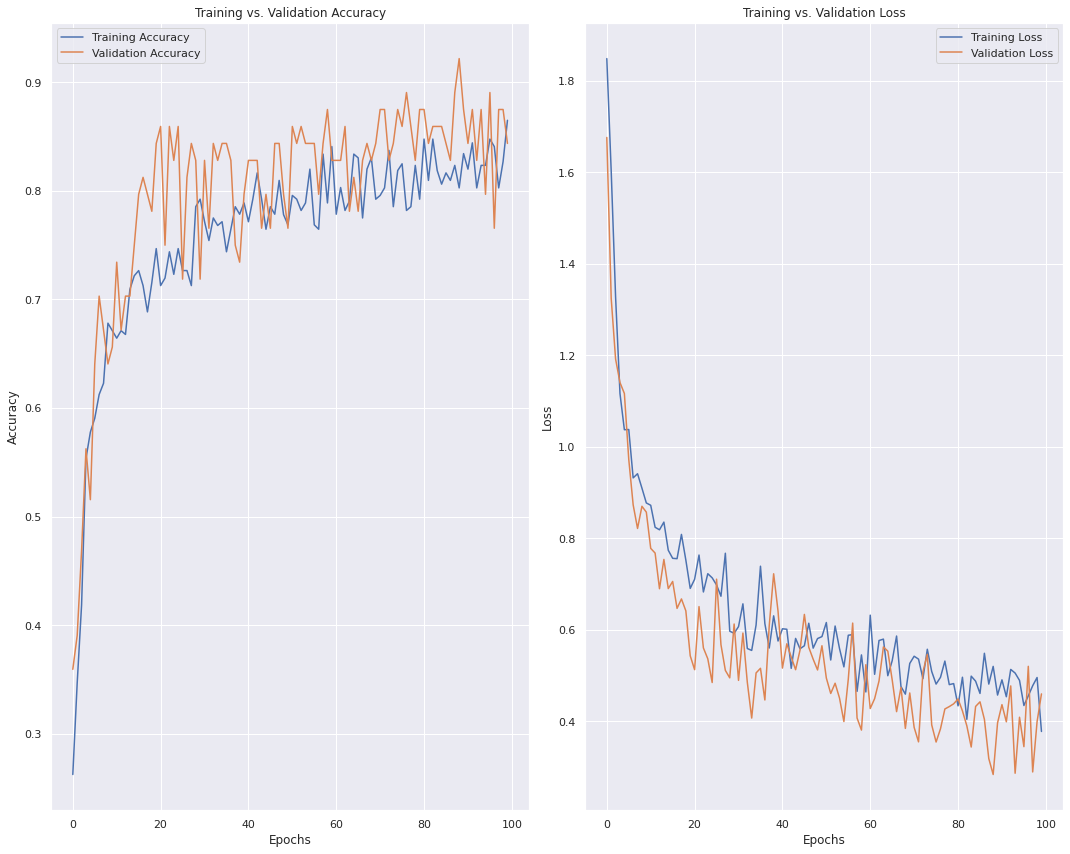

In [ ]:
plot_metrics(history_x)

In [ ]:
model_x.save('/content/drive/MyDrive/Model_Save/experiment model/model_x.h5')

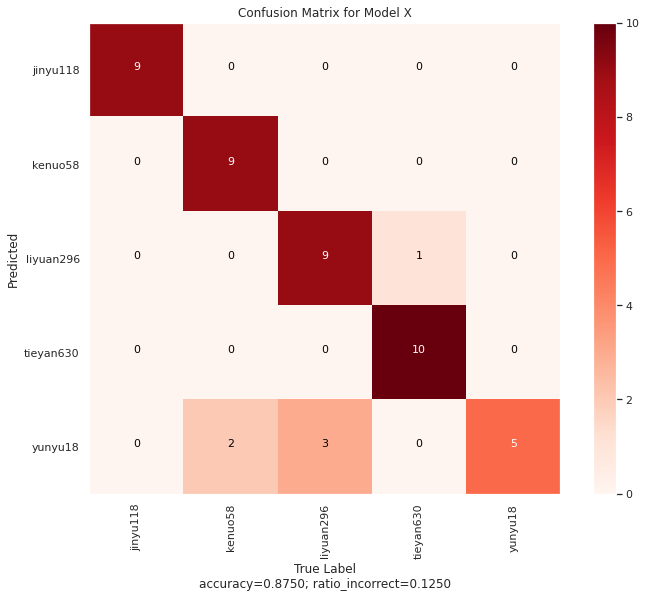

In [ ]:
plot_confusion_matrix(pred, preddir,model_x, pred_gen, 'Model X')

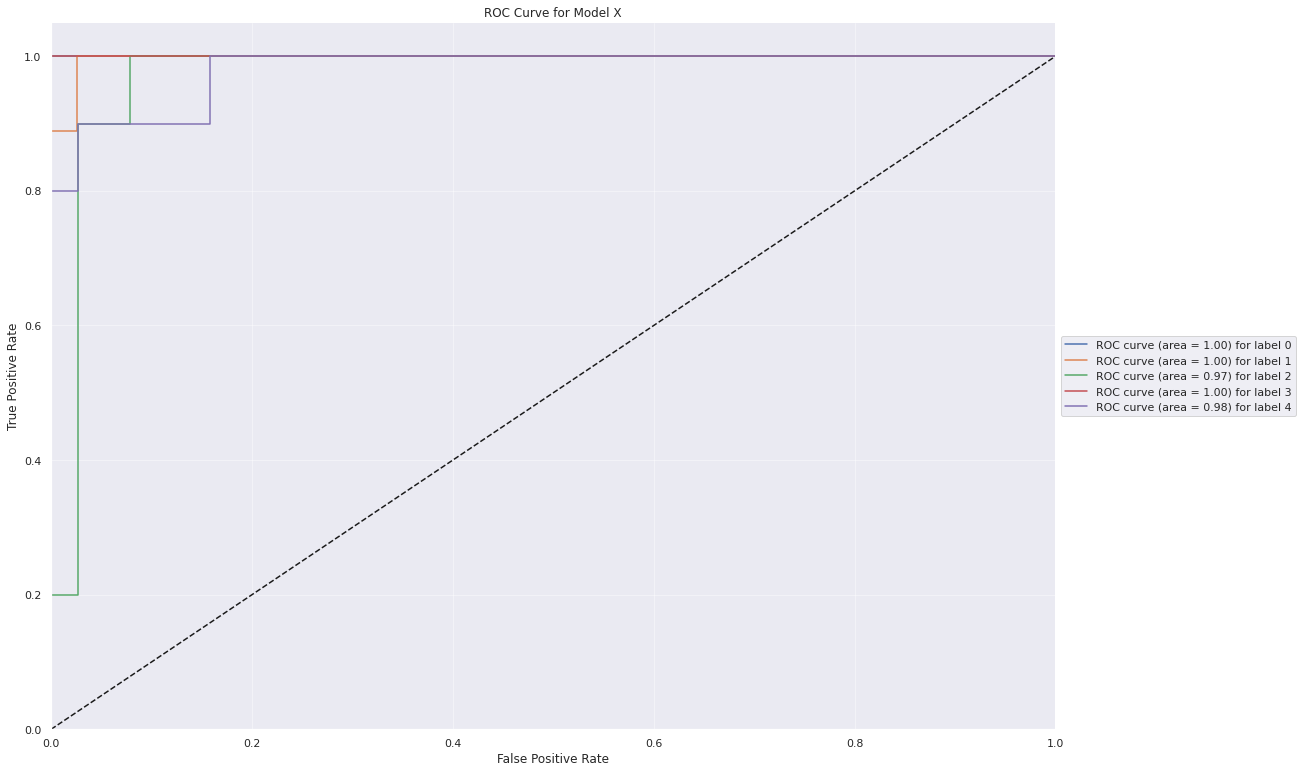

In [ ]:
plot_roc_curve(model_x, pred, pred_gen, 'Model X')

In [ ]:
class_report(pred, model_x, pred_gen)

,jinyu118,kenuo58,liyuan296,tieyan630,yunyu18,accuracy,macro avg,weighted avg
precision,1.0,0.818182,0.750000,0.909091,1.000000,0.875,0.895455,0.894886
recall,1.0,1.000000,0.900000,1.000000,0.500000,0.875,0.880000,0.875000
f1-score,1.0,0.900000,0.818182,0.952381,0.666667,0.875,0.867446,0.864006
support,9.0,9.000000,10.000000,10.000000,10.000000,0.875,48.000000,48.000000
